In [2]:
!pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00



--- Deutsch–Jozsa: n=2, oracle='msb' ---

=== DJ n=2, oracle=msb ===


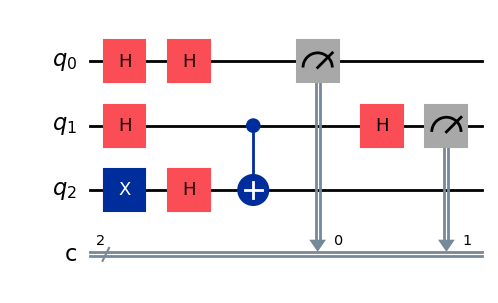

Ideal counts: {'10': 4096}


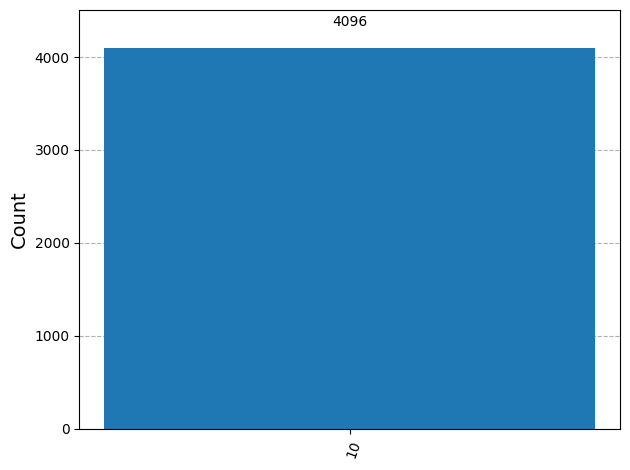


--- Deutsch–Jozsa: n=4, oracle='msb' ---

=== DJ n=4, oracle=msb ===


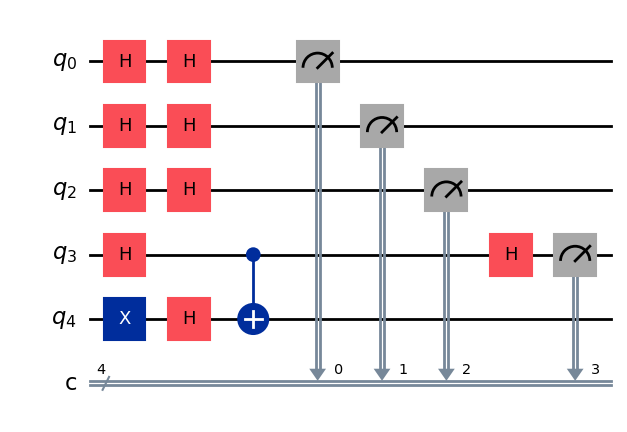

Ideal counts: {'1000': 4096}


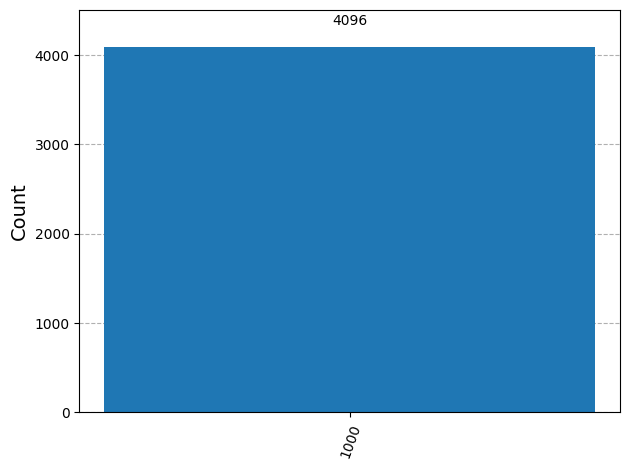


--- Deutsch–Jozsa: n=5, oracle='msb' ---

=== DJ n=5, oracle=msb ===


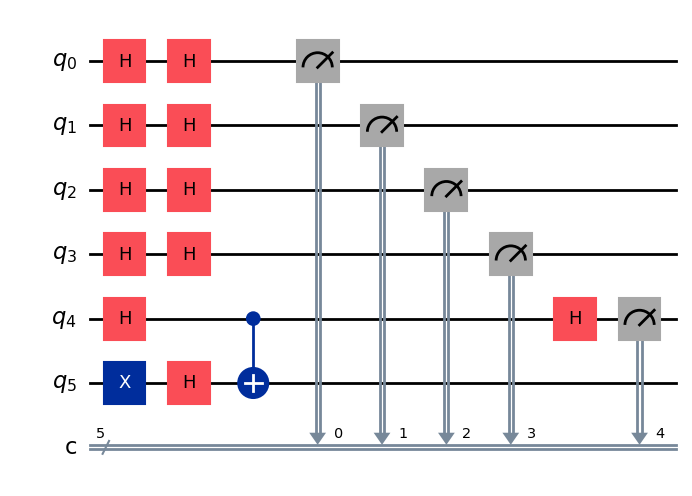

Ideal counts: {'10000': 4096}


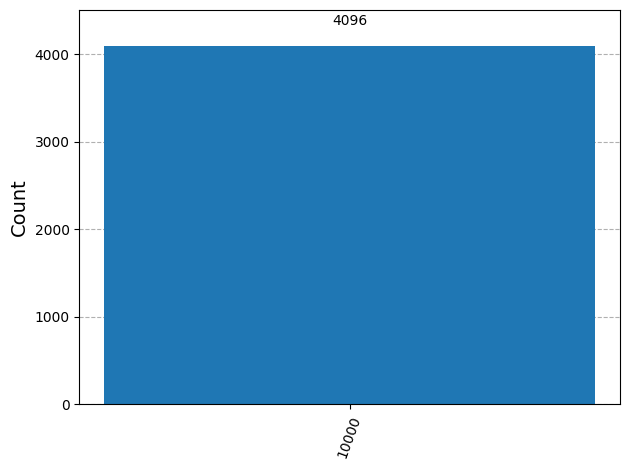

Oracle gate definition (decomposition):
               
q_0: ──■───────
       │       
q_1: ──┼────■──
       │    │  
q_2: ──┼────┼──
     ┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├
     └───┘└───┘

=== DJ n=4, oracle=parity12 ===


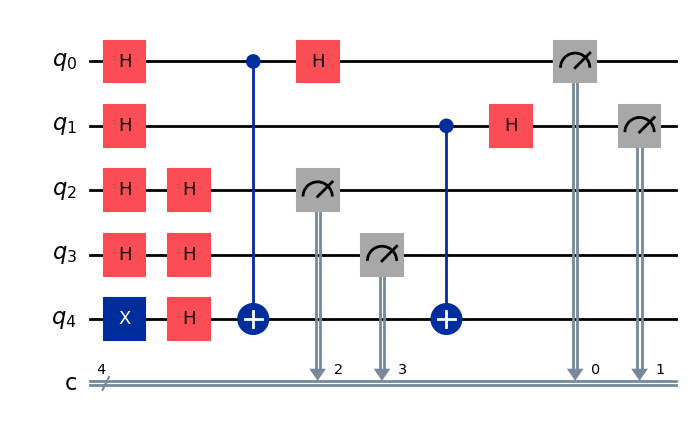

Ideal counts: {'0011': 4096}
Noisy counts: {'0101': 2, '0110': 2, '1000': 1, '1001': 7, '1111': 1, '0001': 203, '0000': 31, '0010': 144, '1011': 72, '0111': 68, '0011': 3565}


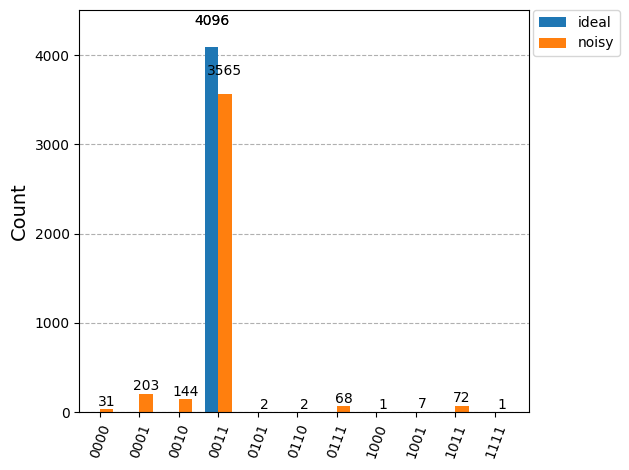

Oracle gate definition (decomposition):
                    
q_0: ───────────────
                    
q_1: ───────────────
                    
q_2: ───────────────
     ┌───┐     ┌───┐
q_3: ┤ X ├──■──┤ X ├
     └───┘┌─┴─┐└───┘
q_4: ─────┤ X ├─────
          └───┘     


In [3]:
# ---------- Deutsch–Jozsa Experiments (single copy-pasteable cell) ----------
# (Optional) install once:
# !pip install qiskit qiskit-aer qiskit-ibm-runtime pylatexenc --quiet

import math
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def safe_draw(qc, title=None):
    if title: print(f"\n=== {title} ===")
    try:
        display(qc.draw('mpl'))
    except Exception:
        print(qc.draw('text'))

def run_simulator(qc, noise_model=None, shots=2048):
    sim = AerSimulator()
    tcirc = transpile(qc, sim)
    if noise_model is None:
        job = sim.run(tcirc, shots=shots)
    else:
        job = sim.run(tcirc, noise_model=noise_model, shots=shots)
    return job.result().get_counts()

def simple_noise_model(p1=0.01, p2=0.03, ro_err=0.02):
    nm = NoiseModel()
    nm.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['h','x'])
    nm.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])
    nm.add_all_qubit_readout_error(ReadoutError([[1-ro_err, ro_err],[ro_err, 1-ro_err]]))
    return nm

# ---------- Deutsch-Jozsa algorithm builder ----------
def deutsch_jozsa_circuit(n, oracle_func):
    """
    n: number of input qubits
    oracle_func: function that takes (qc, input_qubits, ancilla_qubit) and appends oracle in-place
    returns QuantumCircuit measuring input qubits
    """
    qc = QuantumCircuit(n + 1, n)   # n inputs + 1 ancilla, n classical bits for inputs
    inputs = list(range(n))
    anc = n
    # prepare ancilla in |1> then H -> |->:
    qc.x(anc); qc.h(anc)
    # put inputs in superposition
    qc.h(inputs)
    # apply oracle
    oracle_func(qc, inputs, anc)
    # Hadamard on inputs to decode
    qc.h(inputs)
    # measure inputs
    qc.measure(inputs, list(range(n)))
    return qc

# ---------- Task 1: Balanced oracle examples ----------
# Oracle A: flip ancilla when MSB == 1 (exactly half the inputs) -> balanced
def oracle_msb(qc, inputs, anc):
    # flip ancilla when most-significant input (inputs[-1]) is 1
    qc.cx(inputs[-1], anc)

# Oracle B: flip ancilla for a creative half: when parity of first two bits == 1
# uses CX and CCX (for n>=2)
def oracle_parity12(qc, inputs, anc):

    if len(inputs) < 2:
        # fallback to msb if not enough qubits
        qc.cx(inputs[-1], anc)
    else:
        qc.cx(inputs[0], anc)
        qc.cx(inputs[1], anc)


def oracle_msb_zero(qc, inputs, anc):
    # flip ancilla when MSB == 0 -> balanced (half inputs)
    # flip MSB to convert 0->1, apply MCX on that control, then revert
    qc.x(inputs[-1])
    qc.cx(inputs[-1], anc)
    qc.x(inputs[-1])

# You can define more creative balanced oracles by combining cx/ccx/mcx gates.

# ---------- Task 5: Print oracle "unitary" (definition) ----------
def print_oracle_def(oracle_func, n):
    qc_tmp = QuantumCircuit(n+1)
    oracle_func(qc_tmp, list(range(n)), n)
    gate = qc_tmp.to_gate()
    print("Oracle gate definition (decomposition):")
    print(gate.definition)

# ---------- Task 2: Run DJ for different n and oracle choices ----------
def run_experiments(ns=(2,4,5), oracle_choice='msb', iterations=1, show_circuits=True):
    oracle_map = {
        'msb': oracle_msb,
        'parity12': oracle_parity12,
        'msb_zero': oracle_msb_zero
    }
    oracle_func = oracle_map.get(oracle_choice, oracle_msb)
    for n in ns:
        print(f"\n--- Deutsch–Jozsa: n={n}, oracle='{oracle_choice}' ---")
        qc = deutsch_jozsa_circuit(n, oracle_func)
        if show_circuits:
            safe_draw(qc, title=f"DJ n={n}, oracle={oracle_choice}")
        counts = run_simulator(qc, noise_model=None, shots=4096)
        print("Ideal counts:", counts)
        display(plot_histogram(counts))
        plt.show()

# ---------- Task 3: Noise simulation (compare ideal vs noisy) ----------
def dj_with_noise(n, oracle_choice='msb'):
    oracle_map = {
        'msb': oracle_msb,
        'parity12': oracle_parity12,
        'msb_zero': oracle_msb_zero
    }
    oracle_func = oracle_map.get(oracle_choice, oracle_msb)
    qc = deutsch_jozsa_circuit(n, oracle_func)
    safe_draw(qc, title=f"DJ n={n}, oracle={oracle_choice}")
    counts_ideal = run_simulator(qc, noise_model=None, shots=4096)
    noise = simple_noise_model(p1=0.01, p2=0.03, ro_err=0.02)
    counts_noisy = run_simulator(qc, noise_model=noise, shots=4096)
    print("Ideal counts:", counts_ideal)
    print("Noisy counts:", counts_noisy)
    display(plot_histogram([counts_ideal, counts_noisy], legend=['ideal','noisy']))
    plt.show()
    return counts_ideal, counts_noisy


run_experiments(ns=(2,4,5), oracle_choice='msb', show_circuits=True)

# Task 1 demo: show a non-parity balanced oracle (parity12) for n=3
print_oracle_def(oracle_parity12, n=3)

# Task 3 demo: noise comparison for n=4 using oracle 'parity12'
dj_with_noise(n=4, oracle_choice='parity12')

# Task 5: print unitary decomposition (oracle gate definition) for msb_zero at n=4
print_oracle_def(oracle_msb_zero, n=4)

# --------------------------------------------------------------------------------
# You can change oracle_choice to 'msb', 'parity12', or 'msb_zero' (or add your own),
# change ns for Task 2, tune noise parameters in simple_noise_model, or
# uncomment the IBM runtime block and set your backend.
# End of cell.
